In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-play-store-apps/googleplaystore.csv
/kaggle/input/google-play-store-apps/license.txt
/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv


In [98]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lava18/google-play-store-apps")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/google-play-store-apps


Initial shape: (10841, 13)
Final cleaned shape: (8892, 91)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ RMSE: 0.4766
✅ R² Score: 0.1366


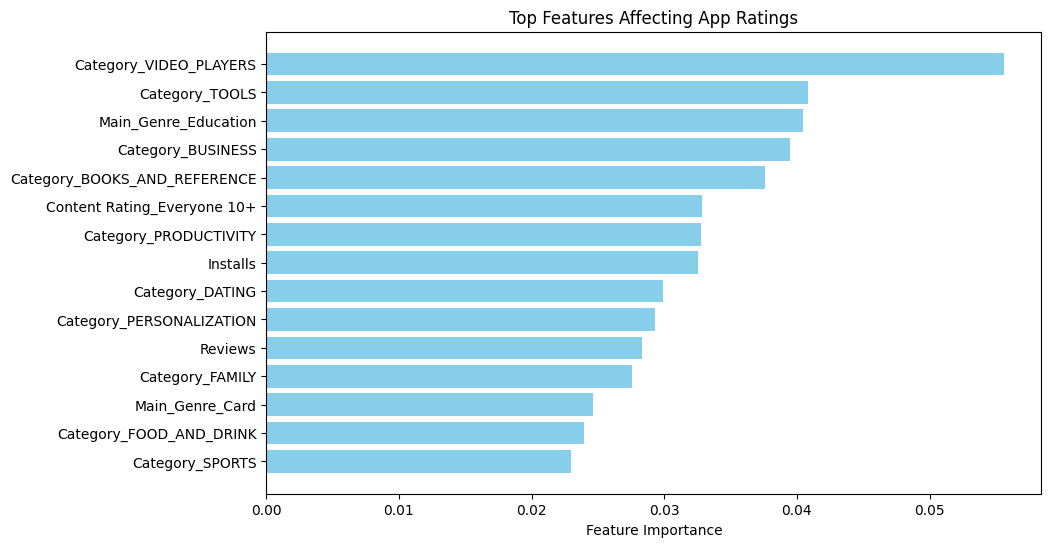

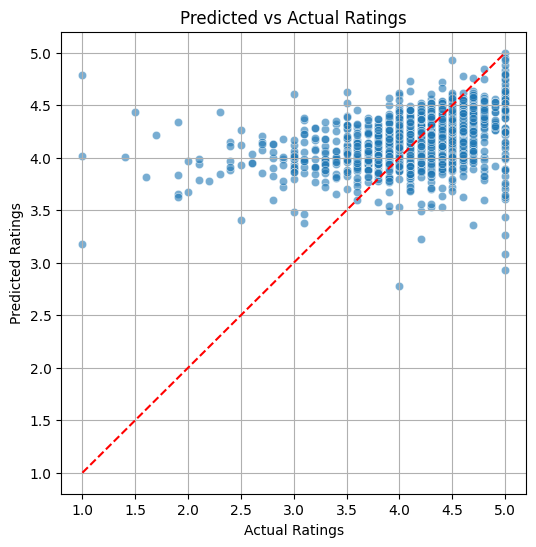

In [99]:
# 📦 Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# 📥 Step 2: Load dataset
df = pd.read_csv("/kaggle/input/google-play-store-apps/googleplaystore.csv")
print("Initial shape:", df.shape)

# 🧹 Step 3: Clean & preprocess

# Drop duplicates and nulls in critical columns
df.drop_duplicates(inplace=True)
df.dropna(subset=["Rating", "Reviews", "Size", "Installs", "Price", "Content Rating", "Type", "Category"], inplace=True)

# Convert rating to float (filter bad rows)
df = df[df["Rating"].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
df["Rating"] = df["Rating"].astype(float)
df = df[df["Rating"] <= 5]

# Clean Reviews
df = df[df["Reviews"].str.isnumeric()]
df["Reviews"] = df["Reviews"].astype(int)

# Clean Installs
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df = df[df['Installs'].str.isnumeric()]
df['Installs'] = df['Installs'].astype(int)

# Clean Price
df['Price'] = df['Price'].astype(str).str.strip()
df['Price_clean'] = df['Price'].str.extract(r'(\d+\.?\d*)')[0]
df['Price_float'] = pd.to_numeric(df['Price_clean'], errors='coerce')
df = df.dropna(subset=['Price_float'])
df['Price'] = df['Price_float']
df.drop(columns=['Price_clean', 'Price_float'], inplace=True)

# Clean Size
def convert_size(size):
    size = str(size).strip()
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024
    else:
        return np.nan

df['Size'] = df['Size'].replace("Varies with device", np.nan)
df['Size'] = df['Size'].apply(convert_size)
df['Size'] = df['Size'].fillna(df['Size'].median())

# 🧠 Step 4: Feature Engineering
df['Installs'] = np.log1p(df['Installs'])
df['Reviews'] = np.log1p(df['Reviews'])

# Days since last updated
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
df['Last_Updated_Days'] = (pd.to_datetime('today') - df['Last Updated']).dt.days
df['Last_Updated_Days'] = df['Last_Updated_Days'].fillna(df['Last_Updated_Days'].median())

# Extract main genre
df['Main_Genre'] = df['Genres'].str.split(';').str[0]

# One-hot encode categorical
df = pd.get_dummies(df, columns=["Category", "Content Rating", "Type", "Main_Genre"], drop_first=True)

# Drop non-numeric columns
df.drop(columns=['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True, errors='ignore')

# ✔️ Final shape
print("Final cleaned shape:", df.shape)

# 🎯 Step 5: Train/test split
X = df.drop("Rating", axis=1)
y = df["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Step 6: GridSearchCV tuning for XGBoost
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3,
                    scoring='neg_root_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

# 🎉 Step 7: Best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 🔍 Step 8: Feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], color="skyblue")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top Features Affecting App Ratings")
plt.show()

# 📊 Step 9: Prediction visualization
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([1, 5], [1, 5], '--r')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.grid()
plt.show()


In [105]:
import joblib
joblib.dump(best_model, 'uiux_rating_predictor.pkl')


['uiux_rating_predictor.pkl']